# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth

import numpy as np
import matplotlib.pyplot as plt

## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [2]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [3]:
from dp_policy.titlei.utils import get_saipe

saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                               cv  
State FIPS Code District ID        
1               190          0.23  
                5            0.23  
                30           0.28  
                60           0.35  
                90           0.23

In [4]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [16]:
weighting(1559, 10000)

NameError: name 'weighting' is not defined

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


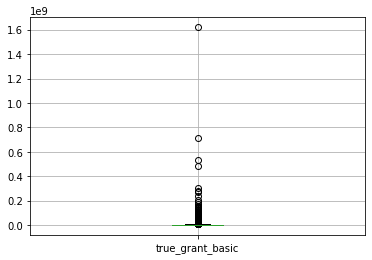

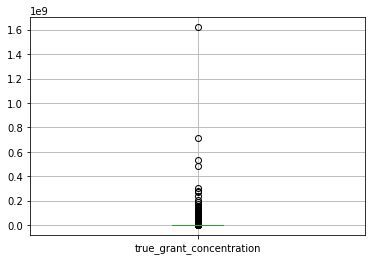

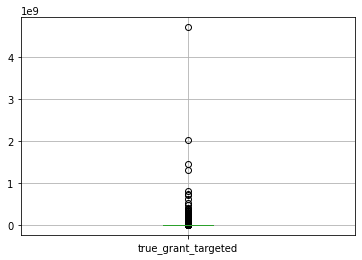

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [7]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190            3.466766e+04
                  5              2.205298e+04
                  30             1.691947e+04
                  60             8.881616e+03
                  90             2.204231e+04
                                     ...     
 56               6240           7.110393e+03
                  5820           6.672346e+02
                  4830           5.437519e+03
                  6090           1.459886e+03
 72               30             3.193688e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6701.718173
                  5                4157.810163
                  30               2614.988588
                  60               1474.190855
                  90               3078.219502
                                     ...      
 56               6240             1276.989969
                  5820              104

### Results
First, using the full Sonnenberg authorization algo.

In [10]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049287e+03,625.252090,625.253224,625.252090,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026324e+06,2.231903e+06,5.061881e+06
std,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728793e+04,3467.141049,3467.140325,3467.141049,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912447e+07,1.908713e+07,5.239817e+07
min,0.000000e+00,0.000000e+00,0.000000,0.150000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.802000e+03,4.260000e+02,52.000000,0.230000,2.802092e+03,4.259423e+02,52.020225,52.000000,52.020225,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.613134e+05,0.000000e+00,1.923918e+05
50%,7.911000e+03,1.186000e+03,147.000000,0.350000,7.910936e+03,1.186118e+03,147.214703,147.000000,147.214703,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.503312e+05,0.000000e+00,7.282260e+05
75%,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101810e+04,3.222008e+03,411.257487,411.000000,411.257487,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.076260e+06,9.149805e+05,2.290126e+06
max,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259012.023451,259012.000000,259012.023451,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619697e+09,1.619697e+09,4.714288e+09


In [33]:
import itertools
from dp_policy.titlei.allocators import Allocator

def test_params(saipe, mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0]):
    allocations = []
    print(f"{len(eps)*len(delta)} iters:")
    i = 0
    for d in delta:
        for e in eps:
            print(i, end=" ")
            i += 1
            allocations.append(funding(
                SonnenbergAuthorizer,
                saipe,  
                mech(saipe, e, d), 
                get_sppe("../data/sppe18.xlsx"), 
                verbose=False)
            )
    return pd.concat(allocations, axis=0, join="inner", keys=itertools.product(delta, eps), names=["delta", "epsilon", "id"])

calc_total = SonnenbergAuthorizer.calc_total

def plot_results(results, delta=False):
    results = calc_total(results)
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        ids = alloc.index.get_level_values("id").astype('str')
        plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

test_params(saipe, Laplace, eps=[0.1, 1.0], delta=[0.0]).head()

2 iters:
0 1 

State Postal Code                                 Name  \
delta epsilon id                                                          
0.0   0.1     0                 AL       Alabaster City School District   
              1                 AL     Albertville City School District   
              2                 AL  Alexander City City School District   
              3                 AL       Andalusia City School District   
              4                 AL        Anniston City School District   

                  true_pop_total  true_children_total  true_children_poverty  \
delta epsilon id                                                               
0.0   0.1     0            34669                 6710                    649   
              1            22051                 4131                    957   
              2            16920                 2575                    703   
              3             8842                 1465                    406   
              4            22043                 3065                   1057   

                    cv  est_pop_total  est_children_total  \
delta epsilon id                                            
0.0   0.1     0   0.23   34637.693652         6722.186415   
              1   0.23   22029.178072         4130.785528   
              2   0.28   16939.991568         2547.108185   
              3   0.35    8826.259926         1472.046045   
              4   0.23   22045.185393         3060.509099   

                  est_children_poverty  true_children_eligible  \
delta epsilon id                                                 
0.0   0.1     0             642.919112                     649   
              1             969.396654                     957   
              2             689.022834                     703   
              3             409.996463                     406   
              4            1061.148290                    1057   

                  est_children_eligible    sppe  true_grant_basic  \
delta epsilon id                                                    
0.0   0.1     0              642.919112  9697.0      2.705623e+06   
              1              969.396654  9697.0      3.989647e+06   
              2              689.022834  9697.0      2.930744e+06   
              3              409.996463  9697.0      1.692578e+06   
              4             1061.148290  9697.0      4.406538e+06   

                  true_grant_concentration  true_grant_targeted  \
delta epsilon id                                                  
0.0   0.1     0               0.000000e+00         2.705623e+06   
              1               3.989647e+06         5.091282e+06   
              2               2.930744e+06         4.276260e+06   
              3               1.692578e+06         2.490924e+06   
              4               4.406538e+06         7.792736e+06   

                  est_grant_basic  est_grant_concentration  est_grant_targeted  
delta epsilon id                                                                
0.0   0.1     0      2.680272e+06             0.000000e+00        2.680272e+06  
              1      4.041328e+06             4.041328e+06        5.220483e+06  
              2      2.872474e+06             2.872474e+06        4.164979e+06  
              3      1.709239e+06             1.709239e+06        2.523196e+06  
              4      4.423832e+06             4.423832e+06        7.858321e+06

In [14]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0, 10.0, 20.0])
results.to_csv("../results/titlei_laplace.csv")

5 iters:
0 1 2 3 4 

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [13]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [14]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2832.7968391709787

In [15]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 26137647.773587536


In [16]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1533.3107606128242

In [17]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70036.941471052

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [34]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

510 iters:
0 1 2 

KeyboardInterrupt: 

In [15]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'id'])

0.216


<ipython-input-9-8cbd37b9144c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
<ipython-input-9-8cbd37b9144c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]


## basic grants ##
RMSE at eps=0.1098541141987558: 8883.899858491466
RMSE prop eps=0.1098541141987558: 0.0020543672423645044
Total misalloc at eps=0.1098541141987558: 81835515.59154107
Total true alloc: 39894838662.272514
## concentration grants ##
RMSE at eps=0.1098541141987558: 71368.89019960957
RMSE prop eps=0.1098541141987558: 0.0030989661336924034
Total misalloc at eps=0.1098541141987558: 85467600.58049627
Total true alloc: 29421416873.03583
## targeted grants ##
RMSE at eps=0.1098541141987558: 27030.85089421071
RMSE prop eps=0.1098541141987558: 0.0019056116072240854
Total misalloc at eps=0.1098541141987558: 126872627.07142396
Total true alloc: 66729811774.698265
## total grants ##
RMSE at eps=0.1098541141987558: 80288.6085147622
RMSE prop eps=0.1098541141987558: 0.0021839189956948074
Total misalloc at eps=0.1098541141987558: 293855078.4112137
Total true alloc: 136046067310.00618
## basic grants ##
RMSE at eps=2.5: 4086.2160340285495
RMSE prop eps=2.5: 0.0007420893543783348
Total 

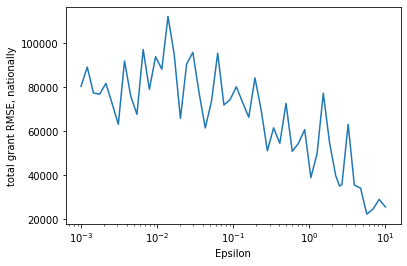

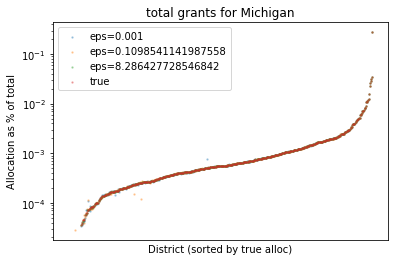

<ipython-input-9-8cbd37b9144c>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


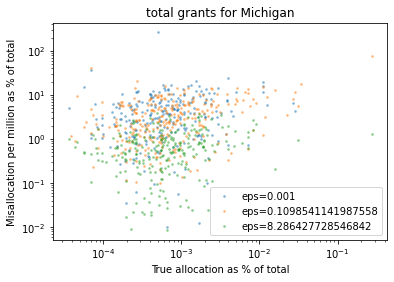

In [16]:
print(results.index.get_level_values('delta').unique()[2])
plot_results(results.xs(results.index.get_level_values('delta').unique()[2], level='delta'))

<ipython-input-11-d548260ed706>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
<ipython-input-11-d548260ed706>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]


## basic grants ##
RMSE at eps=0.1098541141987558: 3377.3774977616863
RMSE prop eps=0.1098541141987558: 0.0005407404945223046
Total misalloc at eps=0.1098541141987558: 20978583.22247984
Total true alloc: 39894838662.272514
## concentration grants ##
RMSE at eps=0.1098541141987558: 30070.27682830566
RMSE prop eps=0.1098541141987558: 0.0007575002944599678
Total misalloc at eps=0.1098541141987558: 21275438.208985526
Total true alloc: 29421416873.03583
## targeted grants ##
RMSE at eps=0.1098541141987558: 13598.354027066682
RMSE prop eps=0.1098541141987558: 0.00048711249702892826
Total misalloc at eps=0.1098541141987558: 32209050.43305158
Total true alloc: 66729811774.698265
## total grants ##
RMSE at eps=0.1098541141987558: 33986.03635430031
RMSE prop eps=0.1098541141987558: 0.0005582405826923902
Total misalloc at eps=0.1098541141987558: 74198807.19590445
Total true alloc: 136046067310.00618
## basic grants ##
RMSE at eps=2.5: 3094.24423724078
RMSE prop eps=2.5: 0.0004094632761867137
Tota

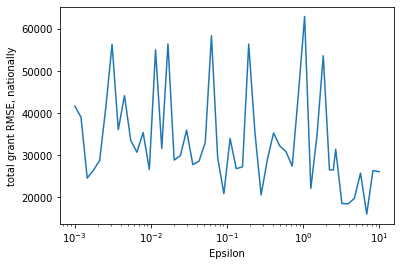

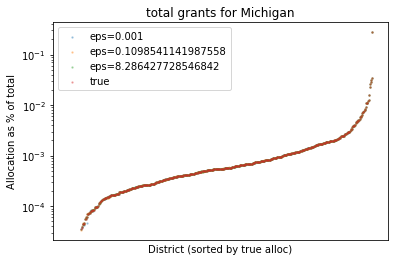

<ipython-input-11-d548260ed706>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


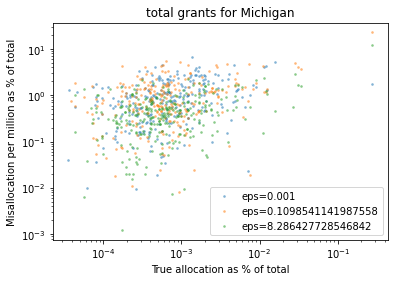

In [47]:
plot_results(results.xs(0.804))

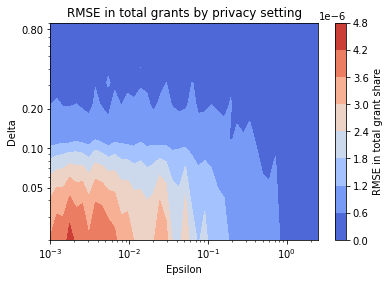

In [135]:
from matplotlib.ticker import FormatStrFormatter

results = calc_total(results)
eps = list(results.index.get_level_values("epsilon").unique())

delts = list(results.index.get_level_values("delta").unique())
mse = np.zeros((len(eps), len(delts)))
for params, alloc in results.groupby(["epsilon", "delta"]):
    
    e, d = params
    error = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]) \
        - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
    mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
    
plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0.05, 0.1, 0.2, 0.8])
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.xlim(None, 2.5)
plt.xlabel("Epsilon")
plt.ylabel("Delta")
plt.title("RMSE in total grants by privacy setting")
plt.colorbar(label="RMSE in total grant share")
plt.show()

# Uncertainty

## Calculating confidence intervals

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


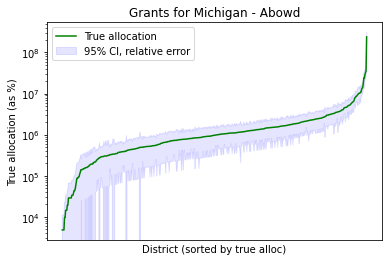

In [5]:
from dp_policy.api import titlei_data as data

# test with one run of abowd
allocator = AbowdAllocator(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_alloc()
allocator.calc_uncertainty()
estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values("true_grant_total")
y = estimates.true_grant_total
x = estimates.index.astype('str')
ax = plt.gca()

plt.plot(x, y, color='green', label="True allocation")
ax.fill_between(x, estimates.true_ci_lower, estimates.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan - Abowd")
ax.legend()
plt.show()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


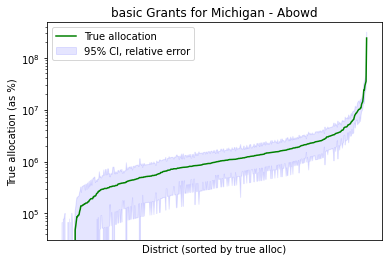

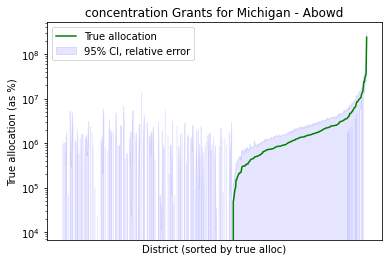

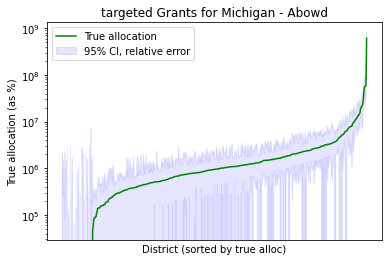

In [61]:
# test with one run of Sonnenberg
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_alloc()
allocator.calc_uncertainty()

for grant_type in ["basic", "concentration", "targeted"]:
    estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values(f"true_grant_{grant_type}")
    y = estimates[f"true_grant_{grant_type}"]
    x = estimates.index.astype('str')
    ax = plt.gca()

    plt.plot(x, y, color='green', label="True allocation")
    ax.fill_between(x, estimates[f"true_grant_{grant_type}_ci_upper"], estimates[f"true_grant_{grant_type}_ci_lower"], color='b', alpha=0.1, label="95% CI, relative error")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"{grant_type} Grants for Michigan - Abowd")
    ax.legend()
    plt.show()

## Results

In [62]:
from dp_policy.titlei.mechanisms import Gaussian, Laplace

# 100 trials of DP
trials_laplace = []
trials_gaussian = []
for i in range(5):
    trials_laplace.append(funding(SonnenbergAuthorizer, saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx")))
    trials_gaussian.append(funding(SonnenbergAuthorizer, saipe, Gaussian(saipe, 2.52, 0.8), get_sppe("../data/sppe18.xlsx")))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


In [63]:
import pickle

pickle.dump(trials_gaussian, open('../results/uncertainty_gaussian_sonnenberg.pkl', 'wb'))
pickle.dump(trials_laplace, open('../results/uncertainty_laplace_sonnenberg.pkl', 'wb'))

In [64]:
import pickle

trials_gaussian = pickle.load( open('../results/uncertainty_gaussian_sonnenberg.pkl', 'rb'))
trials_laplace = pickle.load( open('../results/uncertainty_laplace_sonnenberg.pkl', 'rb'))

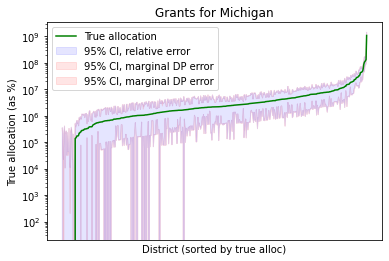

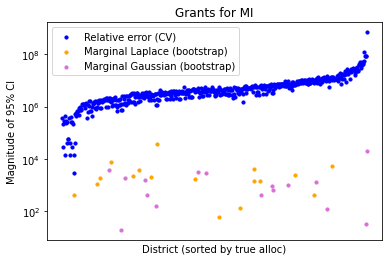

In [99]:
import scipy.stats as stats

def plot_uncertainty(grants, grants_other=None, state="MI", alpha=0.05):
    z = stats.norm.ppf(1-alpha/2)
    
    grants = [
        sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
        for sample in grants
    ]
    baseline = grants[0]
    x = baseline.index.astype('str')
    y = baseline.true_grant_total
    ax = plt.gca()
    plt.plot(x, y, color='green', label="True allocation")
    
    # CI from relative error - 95% of samples differ by at most this much
    ax.fill_between(x, baseline.true_ci_lower, baseline.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
    
    # percentile interval from DP (bootstrapping) - 95% of samples differed by at most this much
    samples_upper = [
        sample.est_ci_upper / sum(sample.est_grant_total) * sum(baseline.true_grant_total)
        for sample in grants
    ]
    samples_lower = [
        sample.est_ci_lower / sum(sample.est_grant_total) * sum(baseline.true_grant_total)
        for sample in grants
    ]
    # get value for which 95% of samples are above (for lower) or below (for upper)
    ci_lower = np.percentile(samples_lower, alpha/2, axis=0)
    ci_upper = np.percentile(samples_upper, 1-alpha/2, axis=0)

    ax.fill_between(x, baseline.true_ci_lower, ci_lower, color='r', alpha=0.1, label="95% CI, marginal DP error")
    ax.fill_between(x, baseline.true_ci_upper, ci_upper, color='r', alpha=0.1, label="95% CI, marginal DP error")
    

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    ax.legend()
    plt.show()
    
    # plot of interval magnitude
    ax = plt.gca()
    ci = np.abs(baseline.true_ci_upper - baseline.true_ci_lower)
    plt.scatter(x, ci, s=10, color='b', label="Relative error (CV)")
    
    samples = [
        np.abs(sample.est_ci_upper - sample.est_ci_lower) / sum(sample.est_grant_total) * sum(baseline.true_grant_total)
        for sample in grants
    ]
    plt.scatter(x, np.percentile(samples, 1-alpha/2, axis=0) - ci, s=10, color='orange', label="Marginal Laplace (bootstrap)")
    
    if grants_other is not None:
        grants_other = [
            sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
            for sample in grants_other
        ]
        samples_other = [
            np.abs(sample.est_ci_upper - sample.est_ci_lower) / sum(sample.est_grant_total) * sum(baseline.true_grant_total)
            for sample in grants_other
        ]
        plt.scatter(
            x, 
            np.percentile(samples_other, 1-alpha/2, axis=0) - ci,
            s=10, color='orchid', label="Marginal Gaussian (bootstrap)"
        )


    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Magnitude of 95% CI")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()

plot_uncertainty(trials_laplace, trials_gaussian)
# plot_uncertainty(grants_laplace)

# Discrimination
## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [121]:
from dp_policy.titlei.utils import get_acs_data

demographics = get_acs_data(
    "../data/discrimination/CDP05.txt",
    "demo"
)
print(demographics.shape)
social = get_acs_data(
    "../data/discrimination/CDP02.txt",
    "social"
)
print(social.shape)
economic = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "social"
)
print(economic.shape)
housing = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "housing"
)
print(housing.shape)

(11721, 256)
(11720, 340)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 202)
(11721, 202)


In [122]:
acs = demographics.join(social, lsuffix="demo", rsuffix="social", how="inner")\
    .join(economic, rsuffix="econ", how="inner")\
    .join(housing, rsuffix="housing", how="inner")
print(acs.shape)

(11720, 1000)


In [123]:
saipe = get_saipe("../data/saipe19.xls")
saipe = saipe.join(acs, how="inner")

In [127]:
from dp_policy.titlei.mechanisms import Gaussian

results = test_params(
    saipe,
    Gaussian, 
    eps=[0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 15.0],
    delta=[0.1]
)

9 iters:
0 1 2 3 4 5 6 

KeyboardInterrupt: 

In [ ]:
grants = calc_total(results)
# for regression
grants["error"] = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
grants.to_csv("../results/discrimination.csv")

### Plot for just (0.1, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 0.1, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


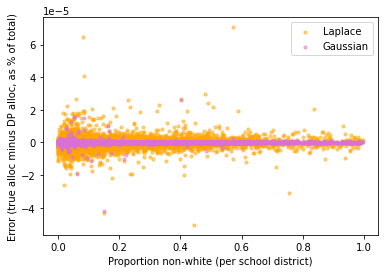

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()